# Import

In [145]:
from jesse.strategies import Strategy, cached
import jesse.indicators as ta
from jesse import utils
from jesse import research
from pprint import pprint
from pykalman import KalmanFilter
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
import requests
import pandas as pd
import time
import tqdm
import json
import pickle
import missingno
import sys
from sklearn.manifold import TSNE
from sklearn import linear_model
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
import statsmodels.api as sm
import itertools
from itertools import product
from collections import Counter

# Data Preparation and Preprocessing

### Glassnode Preparation

In [2]:
# Dataset Loading
with open('./glassnode_defis', 'rb') as f:
    gn_defis = pickle.load(f)

In [3]:
# extract glassnode dataframe
gn_dict = {}
for a in tqdm.tqdm(gn_defis.keys()):
    cols = []
    for k in (gn_defis[a].keys()):
        if not gn_defis[a][k]: continue
        _d = pd.DataFrame(gn_defis[a][k]).rename(columns={'t': 'date', "v": k})
        _d['date'] = pd.to_datetime(_d['date'], unit='s')
        _d = _d.set_index('date')
        cols.append(_d)
    gn_dict[a] = pd.concat(cols, axis=1)

100%|███████████████████████████████████████████| 15/15 [00:01<00:00,  8.34it/s]


In [604]:
finals = {'AAVE',
 'BAL',
#  'CELR', ## llama little
 'COMP',
 'CRV',
 'DODO', 
 #'LDO', ## little
 'LRC',
 'MKR',
 'REN',
 #'RSR', ## glassnode inconsistent
 'SNX',
 'SUSHI',
 'UNI',
 'YFI'}

In [608]:
with open('universe_symbols', 'wb') as f:
    pickle.dump(list(finals), f)

In [5]:
for final in finals:
    gn_dict[final].drop('o', inplace=True, axis=1)
_t = []
for final in finals:
    _t.append(gn_dict[final].index.min())
_t = pd.Series(_t)
start_date = _t.max()
start_date

Timestamp('2020-10-02 00:00:00')

### Glassnode Preprocessing

In [6]:
exclude_cols = [
#     'uniswap_liquidity_latest',
    
]
miss_cols = [
    'non_zero_count',
    'nvt',
    'nvts',
    'velocity',
    'transfers_between_exchanges_count',
    'transfers_volume_between_exchanges_sum',
    'transfers_volume_to_exchanges_mean',
    'transfers_volume_from_exchanges_mean',
    'transfers_volume_exchanges_net',
    'transfers_to_exchanges_count',
    'transfers_from_exchanges_count',
    'transfers_volume_to_exchanges_sum',
    'transfers_volume_from_exchanges_sum',
    'transfers_volume_within_exchanges_sum',
    'balance_exchanges', 
    'exchange_net_position_change',
    'balance_exchanges_relative',
    'balance_1pct_holders',
    'gini',
    'herfindahl', 
    'supply_contracts'
]
cum_cols = [
    'count'
]
norm_cols = [
    'transfers_rate'
]

In [7]:
# exclude missing columes
# exclude big number (only for uniswap series)
# fillna
gn_dict_clean = gn_dict.copy()
for final in tqdm.tqdm(finals):
    for c in gn_dict_clean[final].columns:
        if c in miss_cols:
            gn_dict_clean[final].drop(c, axis=1, inplace=True)
        if 'uniswap' in c:
            gn_dict_clean[final][c].clip(upper=10e10, inplace=True)
            gn_dict_clean[final][c].loc[gn_dict_clean[final][c]>=10e10] = pd.NA
    gn_dict_clean[final].ffill(inplace=True)
    gn_dict_clean[final].fillna(0, inplace=True)

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 33.38it/s]


In [8]:
# add relative difference (return) for all columns
# for each clustering period, calculate the mean of all features and concat them as feature vector 19*2
# cross-sectionally normalize each feature to eiminate scale bias
gn_dict_return = {}
for final in finals:
    _df = gn_dict_clean[final].diff()/gn_dict_clean[final].shift(1)
    cs = list(_df.columns)
    for i in range(len(cs)):
        cs[i] = cs[i]+'_return'
    _df.columns = cs
    gn_dict_return[final] = _df
    gn_dict_clean[final] = pd.concat([gn_dict_clean[final], _df], axis=1)
    
for final in finals:
    gn_dict_clean[final].fillna(0, inplace=True)
    gn_dict_clean[final].replace([np.inf, -np.inf], 0, inplace=True)  
    print(gn_dict_clean[final].shape)

(807, 38)
(841, 38)
(908, 38)
(1471, 38)
(1846, 38)
(804, 38)
(855, 38)
(822, 38)
(1016, 38)
(881, 38)
(1763, 38)
(1810, 38)


### DeFiLlama Preparation and Preprocessing

In [9]:
with open('./defillama_defis', 'rb') as f:
    llama_dict = pickle.load(f)

In [10]:
llama_dfs = {}
for final in tqdm.tqdm(finals):
    cols = []
    for chain in llama_dict[final]['chainTvls'].keys():
        if not chain.isalpha() or not chain[0].isupper():
            continue
        _d = pd.DataFrame(llama_dict[final]['chainTvls'][chain]['tvl']).rename(columns={'totalLiquidityUSD': chain})
        _d['date'] = pd.to_datetime(_d['date'], unit='s')
        _d = _d.set_index('date')
        cols.append(_d)
    llama_dfs[final] = pd.concat(cols, axis=1).ffill().fillna(0)
    
for k in llama_dfs.keys():
    llama_dfs[k] = llama_dfs[k].apply(lambda r: r/r.sum(), axis=1).ffill().fillna(0).replace([np.inf, -np.inf], 0)

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 56.68it/s]


In [11]:
cs = []
for final in finals:
    for c in llama_dfs[final].columns:
        cs.append(c)
        
cs = set(cs)

llama_chain = {}
for final in tqdm.tqdm(finals):
    _n = []
    for c in cs:
        if c in llama_dfs[final].columns:
            _n.append(llama_dfs[final][c])
        else:
            _s = pd.Series(np.zeros(llama_dfs[final].shape[0]))
            _s.name = c
            _s.index = llama_dfs[final].iloc[:, 0].index
            _n.append(_s)
    llama_chain[final] = pd.concat(_n, axis=1)

100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 293.41it/s]


In [12]:
llama_tvl = {}
for final in tqdm.tqdm(finals):
    _d = pd.DataFrame(llama_dict[final]['tvl']).rename(columns={'totalLiquidityUSD': 'TVL'})
    _d['date'] = pd.to_datetime(_d['date'], unit='s')
    _d = _d.set_index('date')
    _d['TVL_return'] = _d['TVL'].diff()/_d['TVL'].shift(1)
    _d.fillna(0, inplace=True)
    _d.replace([np.inf, -np.inf], 0, inplace=True)
    llama_tvl[final] = _d

100%|██████████████████████████████████████████| 12/12 [00:00<00:00, 199.50it/s]


### Overall Preprocessing

In [13]:
_t = []
for final in finals:
    gn = gn_dict_clean[final].index.min()
    chain = llama_chain[final].index.min()
    tvl = llama_chain[final].index.min()
    print(final, gn, chain, tvl)
    _t.append(pd.Series([gn, chain, tvl]).max())
    
_t = pd.Series(_t)
start_date = _t.max()
end_date = pd.to_datetime('2022-12-01')

DODO 2020-09-29 00:00:00 2020-11-09 23:00:00 2020-11-09 23:00:00
SUSHI 2020-08-26 00:00:00 2020-09-04 22:00:00 2020-09-04 22:00:00
BAL 2020-06-20 00:00:00 2020-03-23 23:00:00 2020-03-23 23:00:00
SNX 2018-12-05 00:00:00 2019-08-09 22:00:00 2019-08-09 22:00:00
MKR 2017-11-25 00:00:00 2019-01-04 00:00:00 2019-01-04 00:00:00
AAVE 2020-10-02 00:00:00 2020-05-20 00:00:00 2020-05-20 00:00:00
CRV 2020-08-12 00:00:00 2020-02-09 00:00:00 2020-02-09 00:00:00
UNI 2020-09-14 00:00:00 2018-11-03 00:00:00 2018-11-03 00:00:00
COMP 2020-03-04 00:00:00 2019-05-07 22:00:00 2019-05-07 22:00:00
YFI 2020-07-17 00:00:00 2020-02-12 23:00:00 2020-02-12 23:00:00
LRC 2018-02-16 00:00:00 2020-08-30 00:00:00 2020-08-30 00:00:00
REN 2017-12-31 00:00:00 2020-10-25 23:00:00 2020-10-25 23:00:00


In [574]:
for final in finals:
    _a = (gn_dict_clean[final].isna().any().sum())
    _b = (llama_chain[final].isna().any().sum())
    _c = (llama_tvl[final].isna().any().sum())
    print(final, _a, _b, _c)
    
idx = pd.date_range(start_date.strftime("%m/%d/%Y"), end_date.strftime("%m/%d/%Y"), inclusive='neither')
idx.name = 'date'

# dictionaries: gn_dict_clean, llama_chain, llama_tvl
# clip to same length
# concat data frames
# apply rolling mean
windows = [2, 4, 7, 14, 30] # , 90, 180, 360
rolling = {}
for final in tqdm.tqdm(finals):
    gn = gn_dict_clean[final].query(f'date < "{end_date}"')
    gn.index = gn.index.round('D')
    gn = gn.reindex(idx, method='ffill')
    gn = gn.query(f'date >= "{start_date}"')
    chain = llama_chain[final].query(f'date < "{end_date}"')
    chain.index = chain.index.round('D')
    chain = chain.reindex(idx, method='ffill')
    chain = chain.query(f'date >= "{start_date}"')
    tvl = llama_tvl[final].query(f'date < "{end_date}"')
    tvl.index = tvl.index.round('D')
    tvl = tvl.reindex(idx, method='ffill')
    tvl = tvl.query(f'date >= "{start_date}"')
    
    cs = []
    for window in windows:
        cs.append(gn.rolling(window).mean().ffill().fillna(0))
    rolling[final] = pd.concat(cs, axis=1)
    
for final in finals:
    rolling[final].dropna(how='all', inplace=True)
    print(final, rolling[final].isna().any().sum())

DODO 0 0 0
SUSHI 0 0 0
BAL 0 0 0
SNX 0 0 0
MKR 0 0 0
AAVE 0 0 0
CRV 0 0 0
UNI 0 0 0
COMP 0 0 0
YFI 0 0 0
LRC 0 0 0
REN 0 0 0


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 18.75it/s]

DODO 0
SUSHI 0
BAL 0
SNX 0
MKR 0
AAVE 0
CRV 0
UNI 0
COMP 0
YFI 0
LRC 0
REN 0


In [384]:
gn_dict_clean['AAVE'].columns

Index(['count', 'sending_count', 'receiving_count', 'active_count',
       'new_non_zero_count', 'transfers_count', 'transfers_rate',
       'transfers_volume_sum', 'transfers_volume_mean',
       'transfers_volume_median', 'proof_of_reserves', 'current', 'price_usd',
       'price_usd_close', 'price_drawdown_relative', 'marketcap_usd',
       'uniswap_transaction_count', 'uniswap_liquidity_latest',
       'uniswap_volume_sum', 'count_return', 'sending_count_return',
       'receiving_count_return', 'active_count_return',
       'new_non_zero_count_return', 'transfers_count_return',
       'transfers_rate_return', 'transfers_volume_sum_return',
       'transfers_volume_mean_return', 'transfers_volume_median_return',
       'proof_of_reserves_return', 'current_return', 'price_usd_return',
       'price_usd_close_return', 'price_drawdown_relative_return',
       'marketcap_usd_return', 'uniswap_transaction_count_return',
       'uniswap_liquidity_latest_return', 'uniswap_volume_sum_retur

In [531]:
gn_dict_clean['AAVE']['transfers_rate']

date
2020-10-02    0.021030
2020-10-03    0.042859
2020-10-04    0.015706
2020-10-05    0.011644
2020-10-06    0.011169
                ...   
2022-12-10    0.011863
2022-12-11    0.009838
2022-12-12    0.016898
2022-12-13    0.026389
2022-12-14    0.026389
Freq: D, Name: transfers_rate, Length: 804, dtype: float64

In [502]:
tvl

,TVL,TVL_return
date,,
2020-11-10,2.947708e+08,-0.008693
2020-11-11,2.924975e+08,-0.007712
2020-11-12,3.013501e+08,0.030266
2020-11-13,3.138084e+08,0.041342
2020-11-14,3.143975e+08,0.001877
...,...,...
2022-11-26,6.220282e+07,-0.124234
2022-11-27,6.190831e+07,-0.004735
2022-11-28,5.988216e+07,-0.032728


In [602]:
gn_dict_clean['AAVE'].iloc[-1, :]

count                               4.192840e+05
sending_count                       4.780000e+02
receiving_count                     1.503000e+03
active_count                        1.664000e+03
new_non_zero_count                  1.044000e+03
transfers_count                     2.280000e+03
transfers_rate                      2.638889e-02
transfers_volume_sum                3.077416e+05
transfers_volume_mean               1.349744e+02
transfers_volume_median             7.042200e+00
proof_of_reserves                   1.723056e+06
current                             1.409319e+07
price_usd                           6.259073e+01
price_usd_close                     6.259073e+01
price_drawdown_relative            -9.070486e-01
marketcap_usd                       8.715431e+08
uniswap_transaction_count           4.000000e+00
uniswap_liquidity_latest            1.579473e+03
uniswap_volume_sum                  8.709247e+00
count_return                        0.000000e+00
sending_count_return

In [612]:
gn_dict_clean['AAVE']['price_usd'][::14]

date
2020-10-02      0.516571
2020-10-16     39.495845
2020-10-30     31.276711
2020-11-13     63.399343
2020-11-27     60.794006
2020-12-11     74.898497
2020-12-25     79.621461
2021-01-08    111.568061
2021-01-22    188.279629
2021-02-05    506.772642
2021-02-19    422.039147
2021-03-05    366.963879
2021-03-19    369.383811
2021-04-02    406.417384
2021-04-16    442.160999
2021-04-30    444.882432
2021-05-14    594.830717
2021-05-28    321.063716
2021-06-11    284.469973
2021-06-25    187.121312
2021-07-09    305.169621
2021-07-23    289.905153
2021-08-06    369.911465
2021-08-20    409.029681
2021-09-03    394.594889
2021-09-17    353.296222
2021-10-01    302.401043
2021-10-15    301.155658
2021-10-29    327.477043
2021-11-12    308.603332
2021-11-26    232.179260
2021-12-10    167.838455
2021-12-24    269.828337
2022-01-07    210.540992
2022-01-21    169.733789
2022-02-04    166.360150
2022-02-18    145.916902
2022-03-04    124.000343
2022-03-18    160.933015
2022-04-01    245.56

<AxesSubplot:xlabel='date'>

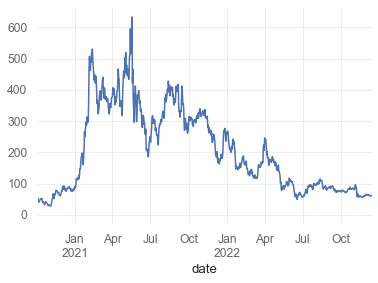

In [610]:
gn_dict_clean['AAVE']['price_usd_close'].plot()

In [613]:
end_date, start_date

(Timestamp('2022-12-01 00:00:00'), Timestamp('2020-11-09 23:00:00'))

In [658]:
### Return features engineering

rolling = {}
windows = [2, 4, 7, 14, 30, 90, 180] # , 90, 180, 360
columns = ['price_usd_return'] # , 'active_count_return', 'transfers_rate'
for final in tqdm.tqdm(finals):
    cs = []
    gn = gn_dict_clean[final].query(f'date < "{end_date}"')
    gn.index = gn.index.round('D')
    gn = gn.reindex(idx, method='ffill')
    gn = gn.query(f'date >= "{start_date}"')
    for window in windows:
        cs.append(gn.rolling(window).mean().ffill().fillna(0)[columns])
#         cs.append(tvl.rolling(window).mean().ffill().fillna(0)['TVL_return'])
    rolling[final] = pd.concat(cs, axis=1)
    
for final in finals:
    rolling[final].dropna(how='all', inplace=True)
    print(final, rolling[final].isna().any().sum())

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 23.54it/s]

DODO 0
SUSHI 0
BAL 0
SNX 0
MKR 0
AAVE 0
CRV 0
UNI 0
COMP 0
YFI 0
LRC 0
REN 0


In [393]:
rolling['AAVE'].shape

(751, 16)

# Clustering Lab

In [659]:
sample_date = '2022-01-01'
sample_dict = {}
for final in finals:
    sample_dict[final] = rolling[final].query(f'date == "{sample_date}"')
sample = []
for k, v in sample_dict.items():
    v.index = [k]
    sample.append(v)
sample = pd.concat(sample)
sample = (sample-sample.mean())/sample.std()
sample.fillna(0, inplace=True)

In [660]:
sample.head(1)

,price_usd_return,price_usd_return,price_usd_return,price_usd_return,price_usd_return,price_usd_return,price_usd_return
DODO,-0.396792,-0.814313,-0.672462,-0.754434,-1.351714,-0.50716,-0.049302


In [661]:
pca = PCA(svd_solver='full', n_components=7)
sample_pca = pca.fit_transform(sample)
pca.explained_variance_ratio_

array([0.48981443, 0.27376651, 0.18469849, 0.03212441, 0.01503845,
       0.00362126, 0.00093644])

In [619]:
pca.explained_variance_ratio_.cumsum()

array([0.44524176, 0.73754998, 0.91852424, 0.96207281, 0.98322608,
       0.99616943, 0.99929001, 1.        ])

In [539]:
X_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(sample_pca)
fig = px.scatter_3d(x=X_embedded[:, 0], y=X_embedded[:, 1], z=X_embedded[:, 2], color=sample.index)
fig.show()

In [137]:
clusters = 6
model = AgglomerativeClustering(n_clusters=clusters, affinity='euclidean', linkage='ward', compute_distances=True)
model.fit(sample)
labels = model.labels_

label_counter = Counter(labels)
# calculate average intra-cluster cointergration score
adfs = []
for k, v in label_counter.items():
    if v < 2:
        continue
    symbols = sample.index[labels==k]
    for symbol1, symbol2 in itertools.combinations(symbols, 2):
        a = gn_dict_clean[symbol1].query(f'date < "2021-11-01" and date > "2021-01-01"')['price_usd']
        b = gn_dict_clean[symbol2].query(f'date < "2021-11-01" and date > "2021-01-01"')['price_usd']
        _spread = a-b
        adf = sm.tsa.stattools.adfuller(_spread, maxlag=1)
        adfs.append(adf[1])
intra_adf = sum(adfs)/len(adfs)

# calculate average inter-cluster cointergration score
adfs = []
for cluster1, cluster2 in itertools.combinations(label_counter.keys(), 2):
    symbols1 = sample.index[labels==cluster1]
    symbols2 = sample.index[labels==cluster2]
    for symbol1, symbol2 in product(symbols1, symbols2):
        a = gn_dict_clean[symbol1].query(f'date < "2021-11-01" and date > "2021-01-01"')['price_usd']
        b = gn_dict_clean[symbol2].query(f'date < "2021-11-01" and date > "2021-01-01"')['price_usd']
        _spread = a-b
        adf = sm.tsa.stattools.adfuller(_spread, maxlag=1)
        adfs.append(adf[1])
inter_adf = sum(adfs)/len(adfs)

print(intra_adf, inter_adf)

0.09298569257361826 0.15165955447413917


In [541]:
start = '2021-01-01'
end = '2022-01-01'

In [542]:
def reg(x,y):
    regr = linear_model.LinearRegression()
    x_constant = pd.concat([x], axis=1)
    regr.fit(x_constant, y)    
    beta = regr.coef_[0]
    alpha = regr.intercept_
    spread = y - x*beta - alpha
    return spread

for clusters in range(2, 9):
    model = AgglomerativeClustering(n_clusters=clusters, affinity='euclidean', linkage='complete')
    model.fit(sample_pca)
    labels = model.labels_
#     print(labels)

    label_counter = Counter(labels)
    # calculate average intra-cluster cointergration score
    adfs = []
    for k, v in label_counter.items():
        if v < 2:
            continue
        symbols = sample.index[labels==k]
        for symbol1, symbol2 in itertools.combinations(symbols, 2):
#             print('intra', symbol1, symbol2)
            a = gn_dict_clean[symbol1].query(f'date < "{end}" and date > "{start}"')['price_usd']
            b = gn_dict_clean[symbol2].query(f'date < "{end}" and date > "{start}"')['price_usd']
            _spread = reg(a, b)
            adf = sm.tsa.stattools.adfuller(_spread, maxlag=1)
            adfs.append(adf[1])
    intra_adf = sum(adfs)/len(adfs)
    intra_pair = len(adfs)

    # calculate average inter-cluster cointergration score
    adfs = []
    for cluster1, cluster2 in itertools.combinations(label_counter.keys(), 2):
        symbols1 = sample.index[labels==cluster1]
        symbols2 = sample.index[labels==cluster2]
        for symbol1, symbol2 in product(symbols1, symbols2):
#             print('inter', symbol1, symbol2)
            a = gn_dict_clean[symbol1].query(f'date < "{end}" and date > "{start}"')['price_usd']
            b = gn_dict_clean[symbol2].query(f'date < "{end}" and date > "{start}"')['price_usd']
            _spread = reg(a, b)
            adf = sm.tsa.stattools.adfuller(_spread, maxlag=1)
            adfs.append(adf[1])
    inter_adf = sum(adfs)/len(adfs)
    inter_pair = len(adfs)

    print(intra_pair, intra_adf, inter_pair, inter_adf)

39 0.22112538222998118 27 0.2713021095631782
21 0.22931127403777338 45 0.26054862194939143
19 0.24842129331077953 47 0.22666727185119379
14 0.23999013645915587 52 0.23102893152851411
12 0.20705559846305324 54 0.2692201758996872
6 0.23058504907066435 60 0.2612644192335878
5 0.19506224093627375 61 0.26128453761728404


### Pairs Selection Lab

In [603]:
max(1, 2)

2

In [662]:
start = '2021-01-01'
end = '2022-01-01'

In [663]:
# cluster-based selection
clusters = 6
model = AgglomerativeClustering(n_clusters=clusters, affinity='euclidean', linkage='complete')
model.fit(sample_pca)
labels = model.labels_
for i, label in enumerate(labels):
    print(sample.index[i], label)

label_counter = Counter(labels)
# calculate average intra-cluster cointergration score
adfs = []
pairs = []
for k, v in label_counter.items():
    if v < 2:
        continue
    symbols = sample.index[labels==k]
    for symbol1, symbol2 in itertools.combinations(symbols, 2):
        a = gn_dict_clean[symbol1].query(f'date < "{end}" and date > "{start}"')['price_usd']
        b = gn_dict_clean[symbol2].query(f'date < "{end}" and date > "{start}"')['price_usd']
        _spread = reg(a, b)
        adf = sm.tsa.stattools.adfuller(_spread, maxlag=1)
        adfs.append(adf[1])
        pairs.append((symbol1, symbol2))
intra_adf = sum(adfs)/len(adfs)
intra_pair = len(adfs)
print(intra_pair, intra_adf)

DODO 4
SUSHI 5
BAL 0
SNX 0
MKR 0
AAVE 3
CRV 1
UNI 0
COMP 0
YFI 1
LRC 2
REN 4
12 0.10544655561102774


In [664]:
counter = 0
unique = set()
selected_pairs = {}
for i in np.argsort(adfs):
    if pairs[i][0] in unique or pairs[i][1] in unique:
        continue
    counter += 1
    print(pairs[i], adfs[i])
    unique.add(pairs[i][0])
    unique.add(pairs[i][1])
    selected_pairs[pairs[i][0]] = pairs[i][1]
    if counter == 3:
        break

('BAL', 'UNI') 0.025201268289045002
('CRV', 'YFI') 0.02926095946812243
('SNX', 'MKR') 0.06938410890599055


<AxesSubplot:xlabel='date'>

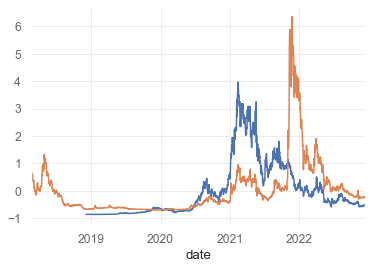

In [497]:
a = gn_dict_clean['SNX']['price_usd']
b = gn_dict_clean['LRC']['price_usd']
a = (a-a.mean())/a.std()
b = (b-b.mean())/b.std()
a.plot()
b.plot()

In [383]:
a = gn_dict_clean['COMP'].query(f'date < "{end}" and date > "{start}"')['price_usd']
b = gn_dict_clean['AAVE'].query(f'date < "{end}" and date > "{start}"')['price_usd']
_spread = reg(a, b)
adf = sm.tsa.stattools.adfuller(_spread, maxlag=1)
print(adf[1])

0.005895103920637685


In [481]:
selected_pairs = {'COMP':'AAVE'} # 'LRC': 'REN'

In [665]:
with open('./pairs', 'wb') as f:
    pickle.dump(selected_pairs, f)

In [558]:
start = '2021-01-01'
end = '2021-12-01'

In [559]:
# cointegration-based selection
adfs = []
pairs = []

for symbol1, symbol2 in itertools.combinations(finals, 2):
    a = gn_dict_clean[symbol1].query(f'date < "{end}" and date > "{start}"')['price_usd']
    b = gn_dict_clean[symbol2].query(f'date < "{end}" and date > "{start}"')['price_usd']
    _spread = reg(a, b)
    adf = sm.tsa.stattools.adfuller(_spread, maxlag=1)
    adfs.append(adf[1])
    pairs.append((symbol1, symbol2))
all_adf = sum(adfs)/len(adfs)
all_pair = len(adfs)
print(all_pair, all_adf)

66 0.2585239234122084


In [560]:
counter = 0
unique = set()
selected_pairs = {}
for i in np.argsort(adfs):
    if pairs[i][0] in unique or pairs[i][1] in unique:
        continue
    counter += 1
    print(pairs[i], adfs[i])
    unique.add(pairs[i][0])
    unique.add(pairs[i][1])
    selected_pairs[pairs[i][0]] = pairs[i][1]
    if counter == 3:
        break

('DODO', 'SUSHI') 7.891828227578653e-05
('COMP', 'YFI') 0.001867324649455261
('BAL', 'AAVE') 0.003073082365229707


In [362]:
selected_pairs

{'MKR': 'LRC', 'BAL': 'CRV', 'DODO': 'SUSHI'}

In [429]:
with open('./pairs', 'wb') as f:
    pickle.dump(selected_pairs, f)

In [311]:
set(list({1:2, 2:3}.keys()) + list({1:2, 2:3}.values()))

{1, 2, 3}

ADF test statistic: -3.19
	1%: -3.452
	5%: -2.871
	10%: -2.572
p-value: 0.021


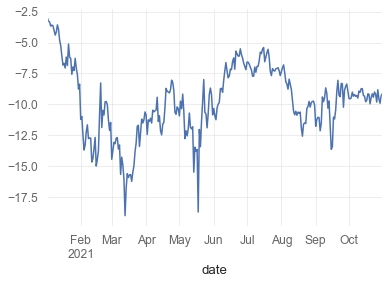

In [731]:
a = gn_dict_clean['DODO'].query(f'date < "2021-11-01" and date > "2021-01-01"')['price_usd']
b = gn_dict_clean['SUSHI'].query(f'date < "2021-11-01" and date > "2021-01-01"')['price_usd']
n_spread = a-b
n_spread.plot()
adf = sm.tsa.stattools.adfuller(n_spread, maxlag=1)
print('ADF test statistic: %.02f' % adf[0])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %.03f' % adf[1])

ADF test statistic: -2.49
	1%: -3.452
	5%: -2.871
	10%: -2.572
p-value: 0.117


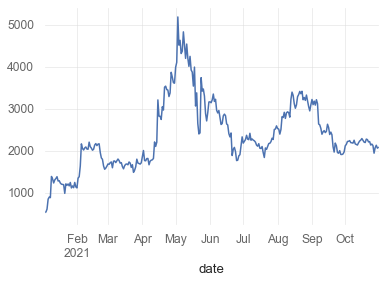

In [736]:
a = gn_dict_clean['MKR'].query(f'date < "2021-11-01" and date > "2021-01-01"')['price_usd']
b = gn_dict_clean['COMP'].query(f'date < "2021-11-01" and date > "2021-01-01"')['price_usd']
n_spread = a-b
n_spread.plot()
adf = sm.tsa.stattools.adfuller(n_spread, maxlag=1)
print('ADF test statistic: %.02f' % adf[0])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
print('p-value: %.03f' % adf[1])